# **Introduction:**

The goal is to build a model capable of doing breed classification of a dog by just “looking” into its image. I started thinking about possible approaches to build a model for doing this and what accuracy it might be able to achieve. It appears that with modern machine learning frameworks like TensorFlow and publicly available datasets and pre-trained models for image recognition the task could be solved with a pretty good accuracy without applying too many efforts and spending too much time and resources.
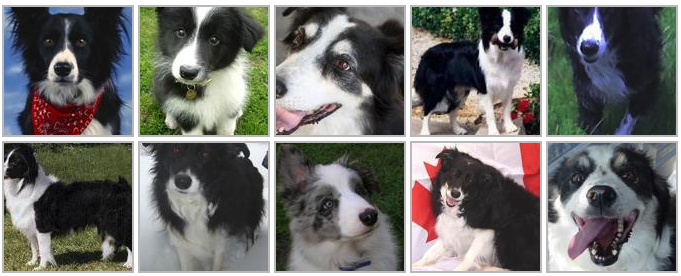

# **Transfer Learning**:

Transfer learning from pretrained models can be fast in use and easy to implement, but some technical skills are necessary in order to avoid implementation errors. Here we describe a fast and easy to understand procedure using data from Kaggle’s Dog Breed Identification competition. 

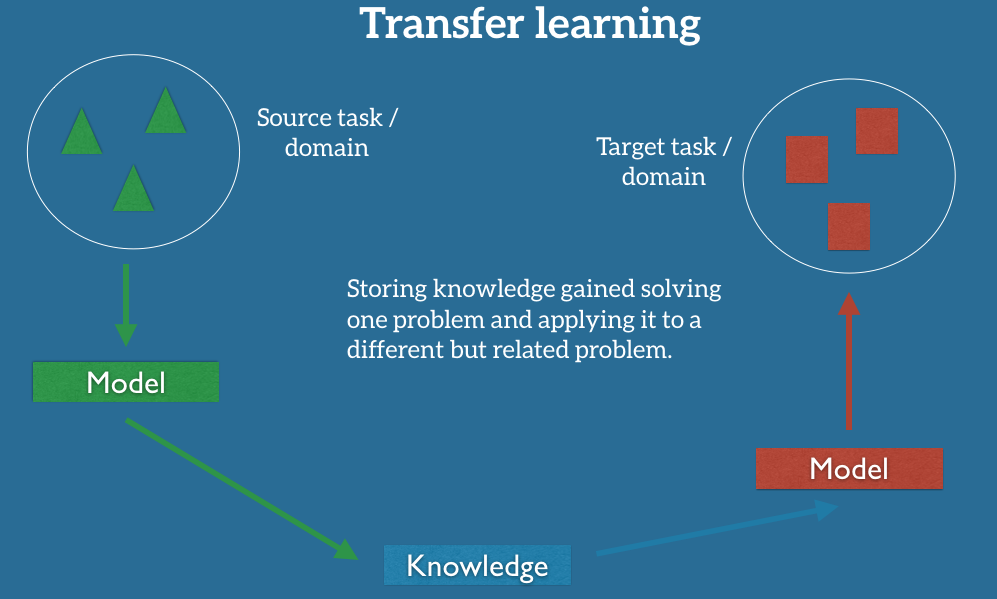


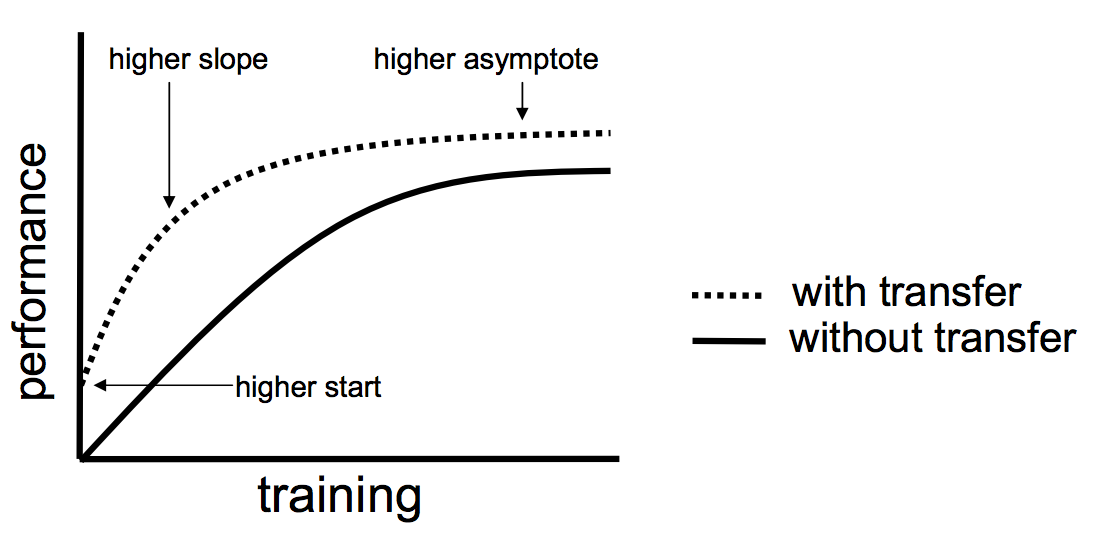



# **Import Packages**

In [ ]:
import cv2
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
import gc

# **Load the dataset**

In [12]:
df_train = pd.read_csv("labels.csv")
df_train.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


# **Visualize training data:**

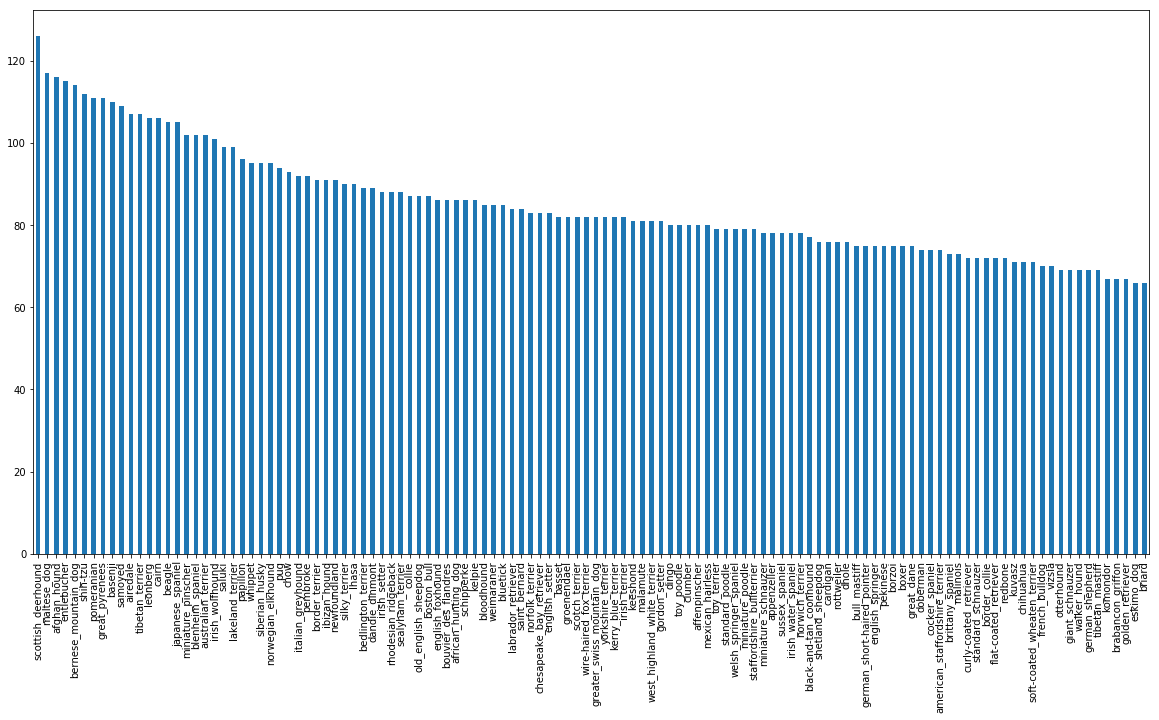

['afghan_hound', 'airedale', 'basenji', 'beagle', 'bernese_mountain_dog', 'cairn', 'entlebucher', 'great_pyrenees', 'japanese_spaniel', 'leonberg', 'maltese_dog', 'pomeranian', 'samoyed', 'scottish_deerhound', 'shih-tzu', 'tibetan_terrier']


In [16]:
#return top 16 value counts and convert into list
plt.figure(figsize=(20, 10))
df_train['breed'].value_counts().plot(kind='bar')
plt.show()

top_breeds = sorted(list(df_train['breed'].value_counts().head(16).index))
top_breeds_df = df_train[df_train['breed'].isin(top_breeds)]

print(top_breeds)

In [17]:
train_label = pd.Series(df_train['breed'])
classes, counts = np.unique(train_label, return_counts=True)
print("Some classes with count:")
print(np.asarray((classes, counts)))
print("Number of class: %d" % classes.size)

Some classes with count:
[['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
  'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
  'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
  'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
  'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
  'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
  'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
  'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber'
  'cocker_spaniel' 'collie' 'curly-coated_retriever' 'dandie_dinmont'
  'dhole' 'dingo' 'doberman' 'english_foxhound' 'english_setter'
  'english_springer' 'entlebucher' 'eskimo_dog' 'flat-coated_retriever'
  'french_bulldog' 'german_shepherd' 'german_short-haired_pointer'
  'giant_schnauzer' 'golden_retriever' 'gordon_setter' 'great_dane'
  'great_pyrenees' 'greater_swiss_mountain_dog' 'groenendael'
  'ibizan_hound' 'irish_setter' 'irish_terrier' 'irish_wa

# **Helper-function**

In [18]:
def plot_images(images, classes):
    assert len(images) == len(classes) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(60,60),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
   
    for i, ax in enumerate(axes.flat):
        # Plot image.
        
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB).reshape(img_width,img_height,3), cmap='hsv')    
        xlabel = "Breed: {0}".format(classes[i])
    
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(60)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [22]:
# parameter
img_width=250
img_height=250
images=[]
classes=[]
#load training images
for f, breed in tqdm(df_train.values):
    img = cv2.imread('/my_data/{}.jpg'.format(f))
    classes.append(breed)
    images.append(cv2.resize(img, (img_width, img_height)))

100%|██████████| 10222/10222 [02:04<00:00, 82.30it/s] 


# **Some example images:**

Images to show: 9
Classes to show: 9


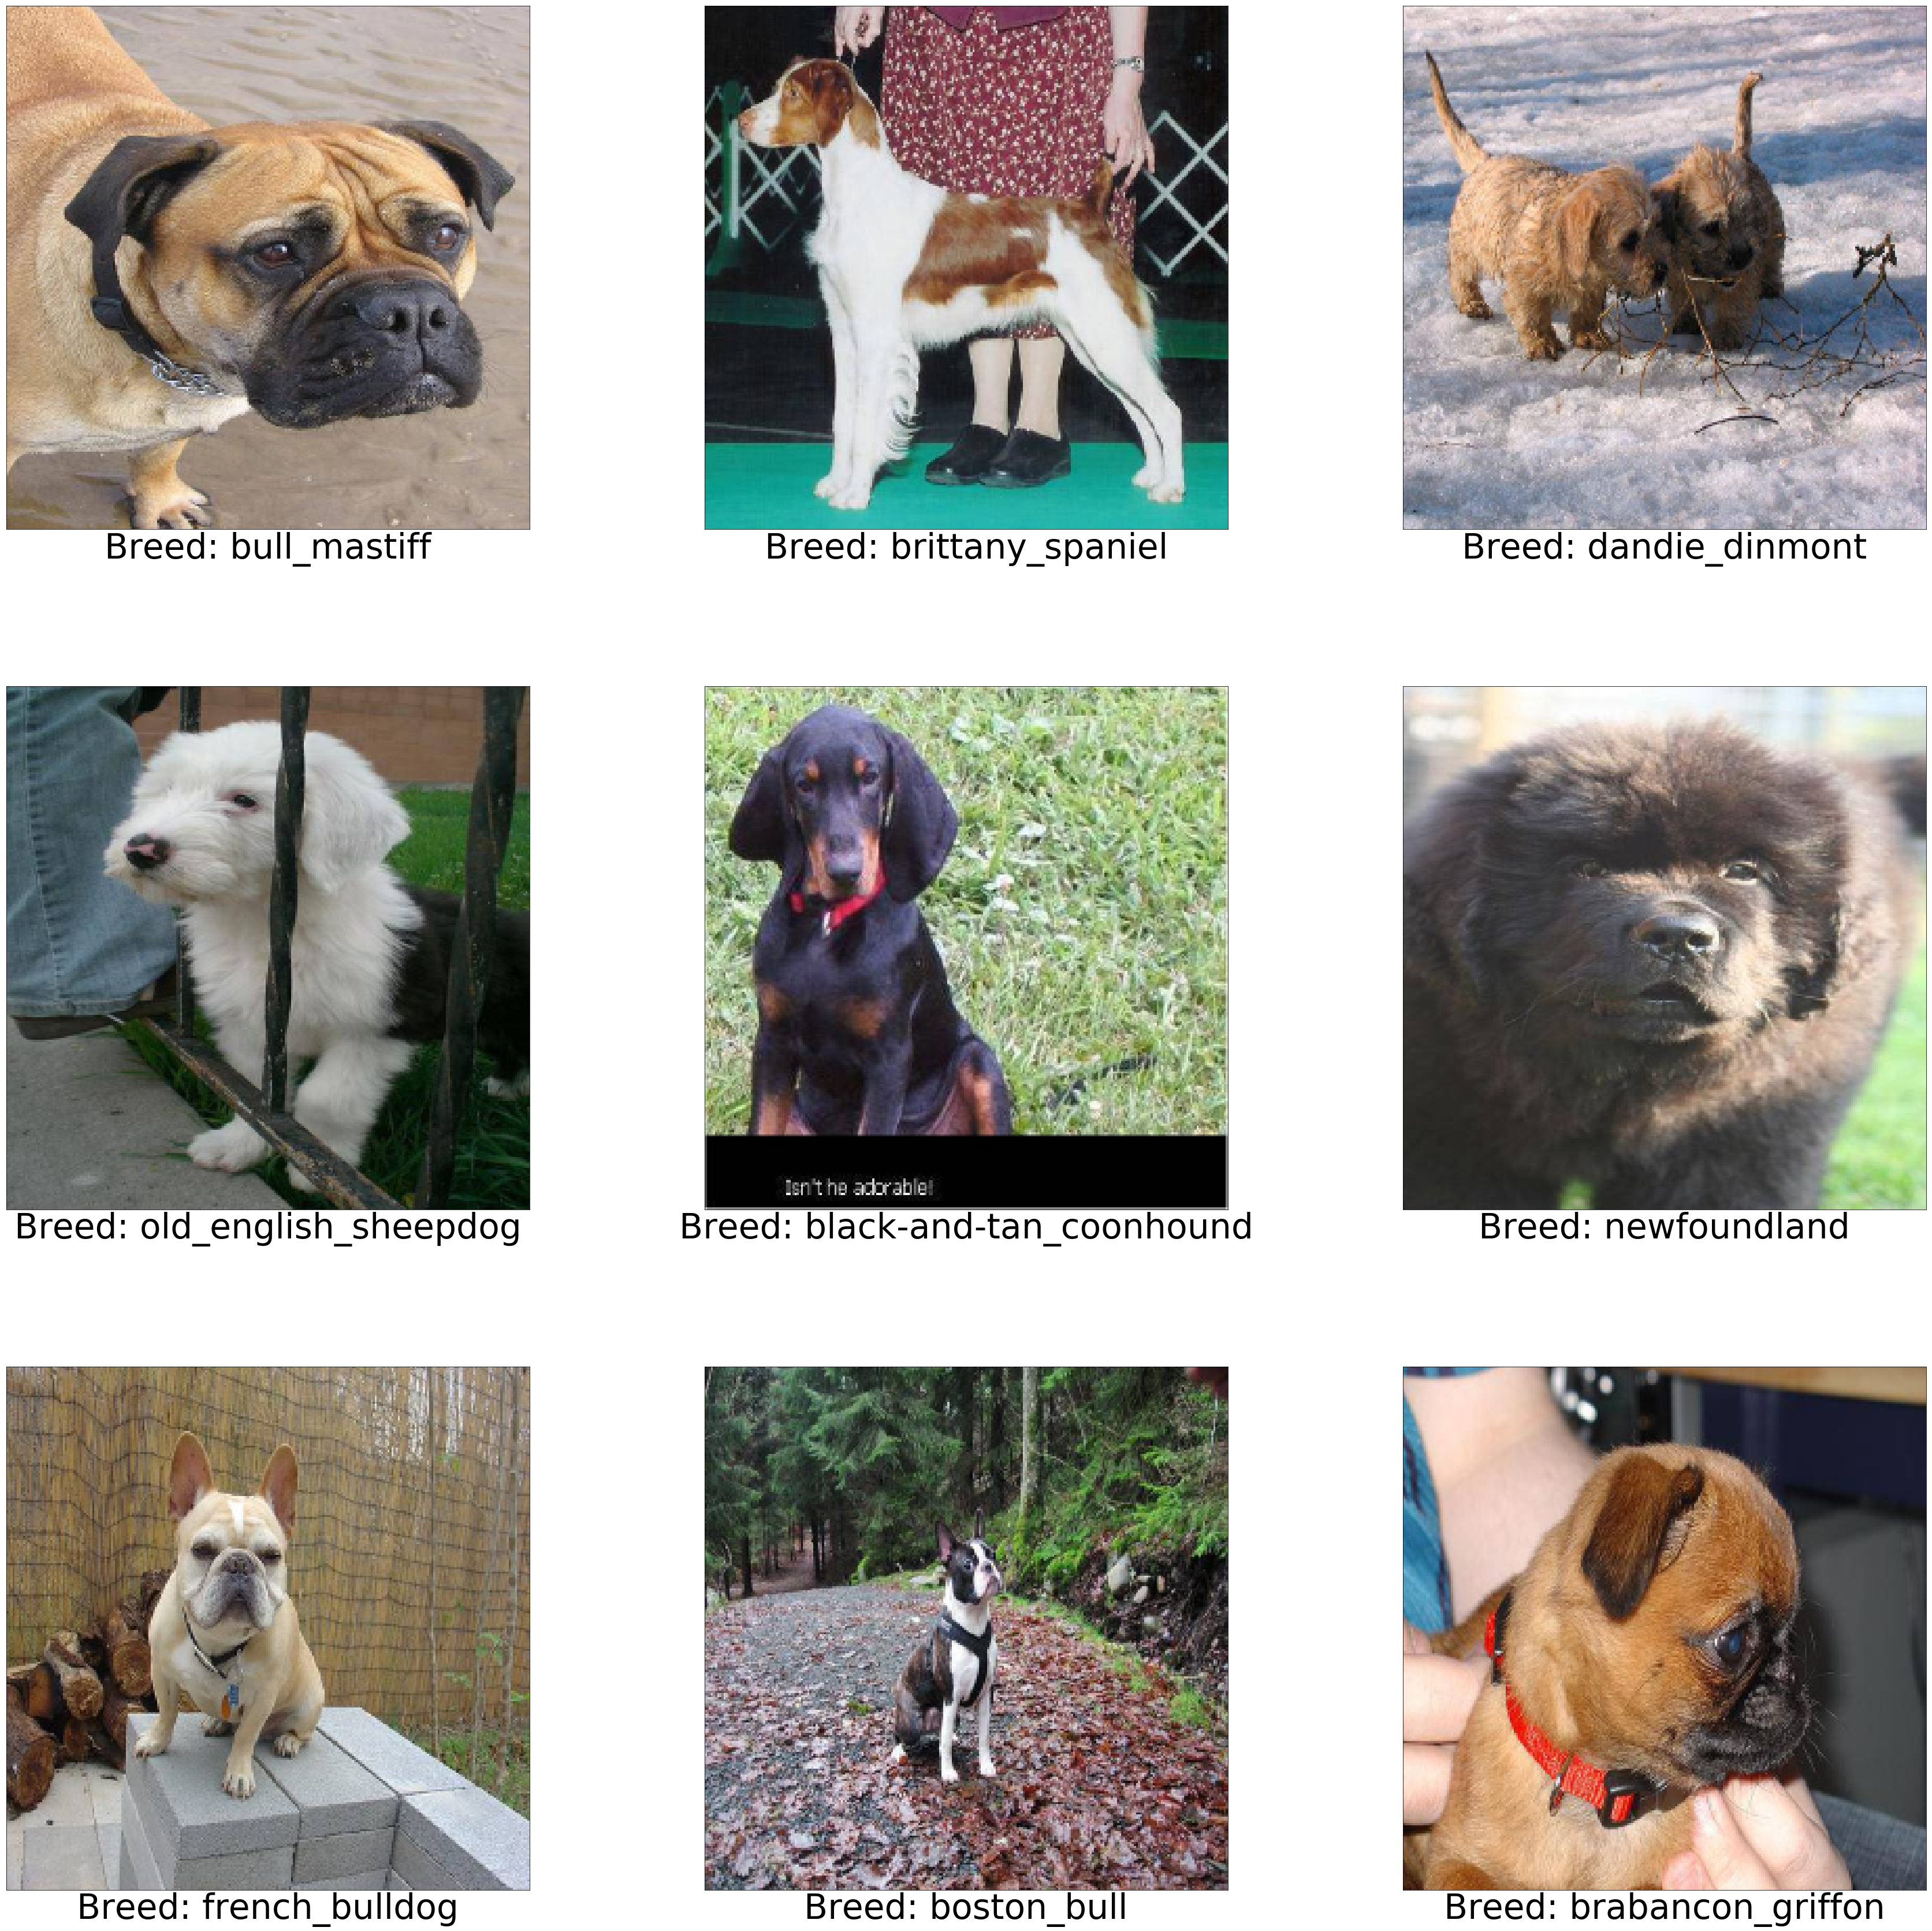

In [24]:
# select random images
random_numbers = [randint(0, len(images)) for p in range(0,9)]
images_to_show = [images[i] for i in random_numbers]
classes_to_show = [classes[i] for i in random_numbers]
print("Images to show: {0}".format(len(images_to_show)))
print("Classes to show: {0}".format(len(classes_to_show)))

#plot the images
plot_images(images_to_show, classes_to_show)

In [ ]:
#path is the path that we save data and dpath the path from where we read data
#paths and dpath can be the same or not
dpath='/my_data/'
labelsdf = pd.read_csv(dpath+'labels.csv')
ssdf = pd.read_csv(dpath+'sample_submission.csv')

# **Preprocessing**

In [ ]:
#Read train images and labels
train_images_len = labelsdf.shape[0]
breed = ssdf.columns[1:]
num_class = len(breed)
width = 299
x_train = np.zeros((train_images_len, width, width, 3), dtype=np.uint8)
y_train = np.zeros((train_images_len, num_class), dtype=np.uint8)
for i in range(train_images_len):
    x_train[i] = cv2.resize(cv2.imread(dpath+'train/%s.jpg' % labelsdf['id'][i]), (width, width), interpolation = cv2.INTER_AREA)
    y_train[i][np.where(breed ==  labelsdf['breed'][i])[0][0] ] = 1

Since OpenCV reads images by default with BGR channel ordering while both our models require images with RGB channel ordering, we have to convert BGR to RGB. After that, we further preprocess the images using the utility function preprocess_input provided by Keras.We also take advantage of the very convenient Numpy function flip, in order to quickly produce horizontal image flippings.This will ncrease the amount of training data,which is another way we can reduce overfitting on models.

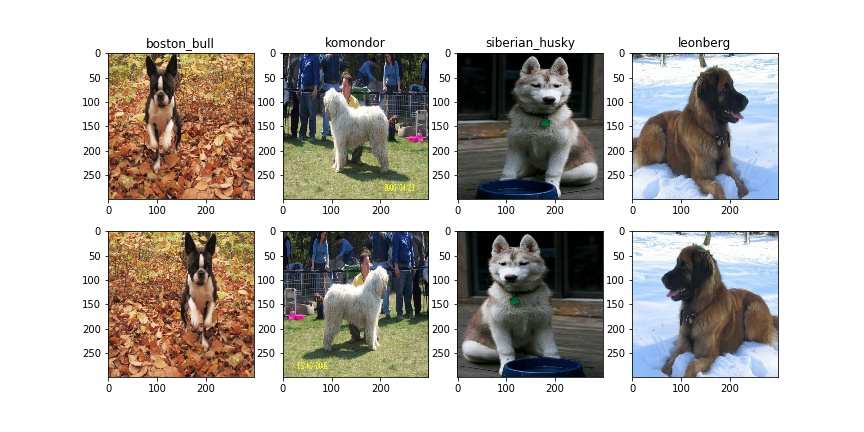

In [ ]:
#BGR to RGB
x_train=x_train[...,::-1]

# **Methodology**

In [ ]:
def get_features(MODEL, data=x_train):
    #Extract Features Function from GlobalAveragePooling2D layer
    pretrained_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet', pooling='avg')
    
    inputs = Input((width, width, 3))
    x = Lambda(preprocess_input, name='preprocessing')(inputs)
    outputs = pretrained_model(x)
    model = Model(inputs, outputs)

    features = model.predict(data, batch_size=64, verbose=1)
    return features

In [ ]:
#Original images(Feature Extraction):
x_xception = get_features(Xception, x_train)
x_inception = get_features(InceptionV3, x_train)
features_train1 = np.concatenate([x_xception, x_inception], axis=-1)

#Flipped images(Feature Extraction):
x_xception = get_features(Xception, np.flip(x_train,axis=2))
x_inception = get_features(InceptionV3, np.flip(x_train,axis=2))
features_train2 = np.concatenate([x_xception, x_inception], axis=-1)

10222/10222 [==============================] - 171s   


In [ ]:
del x_train
gc.collect()

42

In [ ]:
#Read test images 
test_images_len = len(ssdf)
x_test = np.zeros((test_images_len, width, width, 3), dtype=np.uint8)
for i in range(test_images_len):
    x_test[i] = cv2.resize(cv2.imread(dpath+'test/%s.jpg' % ssdf['id'][i]), (width, width))

In [ ]:
#BGR to RGB
x_test=x_test[...,::-1]

In [ ]:
#Original images(Feature Extraction):
x_test_xception = get_features(Xception, x_test)                                      
x_test_inception = get_features(InceptionV3, x_test)
features_test1 = np.concatenate([x_test_xception, x_test_inception], axis=-1)      
#Flipped images(Feature Extraction):
x_test_xception = get_features(Xception, np.flip(x_test,axis=2))                                      
x_test_inception = get_features(InceptionV3, np.flip(x_test,axis=2))
features_test2 = np.concatenate([x_test_xception, x_test_inception], axis=-1)

10357/10357 [==============================] - 175s   
#


In [ ]:
#5 fold predictions with horizontal image flips
allrows=([x for x in range(features_train1.shape[0])])
trainpreds=np.zeros((features_train1.shape[0],120))
testpreds=np.zeros((features_test1.shape[0],120))
callbacks = [EarlyStopping(monitor='val_loss',  patience=3, verbose=1)]

input_shape = features_train1.shape[1:]
for i in range(5):
    inputs = Input(input_shape)
    x = Dropout(0.5)(inputs)
    outputs = Dense(num_class, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='Adagrad', loss='categorical_crossentropy', metrics=['accuracy'])
    
    inputs = Input(input_shape)
    x = Dropout(0.5)(inputs)
    outputs = Dense(num_class, activation='softmax')(x)
    model2 = Model(inputs, outputs)
    model2.compile(optimizer='Adagrad', loss='categorical_crossentropy', metrics=['accuracy'])    
    if i !=4:
        valrows=([x for x in range(2044*i,2044*(i+1))])
        trainrows=([x for x in allrows if x not in valrows])

    else:
        valrows=([x for x in range(2044*i,features_train1.shape[0])])
        trainrows=np.array([x for x in allrows if x not in valrows])        
        
    h = model.fit(features_train1[trainrows,:], y_train[trainrows,:], batch_size=128, epochs=50, 
              validation_data=(features_train1[valrows,:], y_train[valrows,:]), callbacks=callbacks)
    h2 = model2.fit(features_train2[trainrows,:], y_train[trainrows,:], batch_size=128, epochs=50, 
              validation_data=(features_train2[valrows,:], y_train[valrows,:]), callbacks=callbacks)
    
    y_pred_train = model.predict(features_train1[valrows,:], batch_size=128)
    y_pred_train += model2.predict(features_train2[valrows,:], batch_size=128)
    trainpreds[valrows,:]=y_pred_train/2
    y_pred = model.predict(features_test1, batch_size=128)
    y_pred2 = model2.predict(features_test2, batch_size=128)
    testpreds += (y_pred+y_pred2)/2
testpreds/=5

Train on 8178 samples, validate on 2044 samples
Epoch 1/50
8178/8178 [==============================] - 4s - loss: 0.9946 - acc: 0.7820 - val_loss: 0.3356 - val_acc: 0.9061
Epoch 2/50
8178/8178 [==============================] - 0s - loss: 0.2667 - acc: 0.9237 - val_loss: 0.2918 - val_acc: 0.9119
Epoch 3/50
8178/8178 [==============================] - 0s - loss: 0.2099 - acc: 0.9403 - val_loss: 0.2763 - val_acc: 0.9139
Epoch 4/50
8178/8178 [==============================] - ETA: 0s - loss: 0.1795 - acc: 0.949 - 0s - loss: 0.1797 - acc: 0.9496 - val_loss: 0.2664 - val_acc: 0.9154
Epoch 5/50
8178/8178 [==============================] - 0s - loss: 0.1567 - acc: 0.9557 - val_loss: 0.2660 - val_acc: 0.9154
Epoch 6/50
8178/8178 [==============================] - 0s - loss: 0.1423 - acc: 0.9611 - val_loss: 0.2611 - val_acc: 0.9193
Epoch 7/50
8178/8178 [==============================] - 0s - loss: 0.1301 - acc: 0.9652 - val_loss: 0.2614 - val_acc: 0.9203
Epoch 8/50
8178/8178 [=================

8178/8178 [==============================] - 0s - loss: 0.0982 - acc: 0.9755 - val_loss: 0.2560 - val_acc: 0.9110
Epoch 11/50
8178/8178 [==============================] - 0s - loss: 0.0926 - acc: 0.9765 - val_loss: 0.2509 - val_acc: 0.9114
Epoch 12/50
8178/8178 [==============================] - 0s - loss: 0.0862 - acc: 0.9784 - val_loss: 0.2538 - val_acc: 0.9124
Epoch 13/50
8178/8178 [==============================] - 0s - loss: 0.0822 - acc: 0.9821 - val_loss: 0.2519 - val_acc: 0.9139
Epoch 14/50
8178/8178 [==============================] - 0s - loss: 0.0796 - acc: 0.9817 - val_loss: 0.2530 - val_acc: 0.9124
Epoch 15/50
8178/8178 [==============================] - 0s - loss: 0.0778 - acc: 0.9815 - val_loss: 0.2538 - val_acc: 0.9110
Epoch 00014: early stopping
Train on 8176 samples, validate on 2046 samples
Epoch 1/50
8176/8176 [==============================] - 3s - loss: 0.9434 - acc: 0.7915 - val_loss: 0.3481 - val_acc: 0.9022
Epoch 2/50
8176/8176 [==============================] -

# **Submission File:**

In [ ]:
#Create submission file
for b in ssdf.columns[1:]:
    ssdf[b] = testpreds[:,np.where(breed == b)[0][0]]
ssdf.to_csv('dogbreedsubmission.csv', index=None)

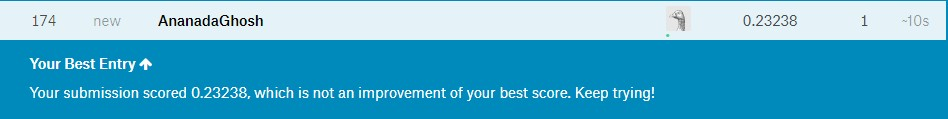